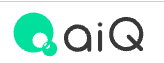

[disclaimer](../../disclaimer.txt/)

# aiQ Pos Consumer Goods/Elec/Retailer Evenly

In this sample notebook, we will create factor returns for three alternative data sources and consider a composite portfolio with an equally-weighted allocation (one-third each). <br>
We confirm that the correlations between each factor return are low and that the composite portfolio exhibits high performance.

- aiQ POS Csmr Goods
- aiQ POS Elec Goods
- aiQ POS Retailer

In [1]:
# Commands to Automatically Update Custom Modules
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.io
from pathlib import Path
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')

from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import aiq_pos_elec_goods as sc_elec
from libs.dataset import aiq_pos_retailer as sc_retailer
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [3]:
verbose = False
sdh = DAL()
sdh.transform.verbose = verbose

## Step2: Load Data to `sdh`
`sdh` is a data container object used within the analysis library all the notebooks utilize. <br>
Since the focus here is on a data analysis demo, we will load the data through a custom loader that has been prepared separately.

In [4]:
dat_id_retail = sc_retailer.register_retailer_data(sdh)
data_id_goods = sc_goods.register_csmr_goods_data(sdh)
data_id_elec = sc_elec.register_elec_goods_data(sdh)
data_id_mkt = sc_common.register_market(sdh, reload=False, yf_switch=False, base_data_id=[dat_id_retail, data_id_goods, data_id_elec])

display(sdh.extract_definition)

category data_source   source    table           alias  \
data_id                                                          
1        RawData    external   sample  Unknown    pos_retailer   
2        RawData    external   sample  Unknown  pos_csmr_goods   
3        RawData    external   sample  Unknown  pos_elec_goods   
4        RawData    External  Unknown  Unknown  market_returns   

                                                   tickers  \
data_id                                                      
1        [1925, 2212, 2267, 2651, 2653, 2659, 2660, 266...   
2        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
3        [1956, 2180, 2321, 2323, 2326, 2354, 2388, 246...   
4        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2010-04-30 00:00:00  2024-07-31 00:00:00  
2        [TICKER, DATETIME]  2008-03-16 00:00:00  2024-07-28 00:00:00  
3        [TICKER, DATETIME]  2009-01-01 00:00:00  2024-07-31 00:00:00  
4        [TICKER, DATETIME]  2007-01-04 00:00:00  2024-07-11 00:00:00

### Set labels to the loaded datasets in `sdh` for easier access later on.

In [5]:
sdh.set_alias(
    {dat_id_retail: 'retail', data_id_goods: 'goods', 
     data_id_elec: 'elec', data_id_mkt: 'mkt'})

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [6]:
USE_MY_MKT = False 

## Step 3: Verify the Factor Returns for Individual Datasets
Before combining, check the performance of each individual factor return.

In [7]:
# Load the objects used in Step 3.
from aiq_strategy_robot.evaluator import AltDataEvaluator, inv_return_stats, cumplot_return

In [8]:
# Create an instance of the main class used for data evaluation.
ade = AltDataEvaluator(sdh)

In [9]:
if USE_MY_MKT:
    # Convert market data from raw values to rate of change.
    bcktest_return_id = sdh.transform.log_diff(1, data_id=data_id_mkt, fields='close').variable_ids[0]
else:
    bcktest_return_id = sdh.transform.raw(data_id=data_id_mkt, fields='returns').variable_ids[0]

### Step3.1: POS CSMR Goods
- Weekly rebalancing
- Data has at least a 4-business-day lag from the end of the week

In [10]:
n_shift = 6    # Considering the timing lag of data issuance
n_rolling = 12 # Calculate the 3-month moving average
n_diff = 52    # Calculate the year-over-year (YoY) comparison for the same week

In [11]:
signal_goods_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_goods)
    .resample('W', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=7)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [12]:
nq = 3
exe_cost = 0.0005

dfqret_goods, stats, dfsigqt = ade.q_backtest(
    signal_goods_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.450610  0.029844  0.133502  0.223551  0.547374      9.691893   
#2           0.964061  0.063851  0.135417  0.471513  0.538711     12.756842   
#3           1.303388  0.086325  0.136017  0.634660  0.552518      9.920706   
#3-#1        0.852778  0.056480  0.048154  1.172914  0.533027     19.612599   
#3-#1(cost)  0.704716  0.046674  0.048164  0.969068  0.529507     19.612599   

               Max_DD  Calmar Ratio  
#1          -0.521708      0.057205  
#2          -0.396555      0.161014  
#3          -0.421545      0.204782  
#3-#1       -0.071782      0.786832  
#3-#1(cost) -0.075392      0.619086

### Step3: POS Retailer
- Monthly rebalancing
- Data has a lag of at least 5 trading days from the end of the month

In [13]:
n_shift = 7   # Consider the timing lag of data issuance
n_rolling = 2 # Calculate the 2-month moving average (since the data is monthly)
n_diff = 12   # Calculate the year-over-year comparison

In [14]:
signal_retailer_id = (
    sdh.transform
    .multiply('pos_sales', 'share', data_id=dat_id_retail)
    .resample('M', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=31)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [15]:
nq = 3
exe_cost = 0.0005

dfqret_retailer, stats, dfsigqt = ade.q_backtest(
    signal_retailer_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.559033  0.042679  0.135648  0.314630  0.528111     10.674087   
#2           1.136862  0.086792  0.141064  0.615270  0.539021     11.719844   
#3           1.805547  0.137842  0.143756  0.958861  0.548010      9.237956   
#3-#1        1.246514  0.095164  0.069908  1.361271  0.536639     19.912043   
#3-#1(cost)  1.116104  0.085208  0.069821  1.220371  0.532217     19.912043   

               Max_DD  Calmar Ratio  
#1          -0.609112      0.070067  
#2          -0.455882      0.190383  
#3          -0.419934      0.328247  
#3-#1       -0.129532      0.734673  
#3-#1(cost) -0.141896      0.600492

### Step3.3: POS Elec Goods
- Daily rebalancing
- Data has at least a 3-business-day lag

In [16]:
n_shift = 8    # Consider the data issuance timing lag
n_rolling = 14 # Calculate the 14-day moving average (data is daily)
n_diff = 252   # To calculate the year-over-year (YoY) change.
min_period = int(max(np.floor(n_rolling * 5 / 7), 1))

In [17]:
signal_elec_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_elec)
    .resample('D', 'last')
    .sma(n_rolling, min_period)
    .reindex(label=bcktest_return_id)
    .log_diff(n_diff)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [18]:
nq = 3
exe_cost = 0.0005

dfqret_elec, stats, dfsigqt = ade.q_backtest(
    signal_elec_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.047084  0.003260  0.201929  0.016146  0.530427     22.866097   
#2           0.975379  0.067542  0.202231  0.333985  0.533258     38.745049   
#3           1.379473  0.095524  0.201753  0.473471  0.542032     23.628700   
#3-#1        1.332390  0.092264  0.114846  0.803369  0.534673     46.494797   
#3-#1(cost)  0.996672  0.069016  0.114835  0.601006  0.529012     46.494797   

               Max_DD  Calmar Ratio  
#1          -0.769670      0.004236  
#2          -0.578774      0.116698  
#3          -0.494871      0.193028  
#3-#1       -0.258826      0.356471  
#3-#1(cost) -0.300985      0.229302

## Step4: Combining Factor Returns
- Create an equally weighted portfolio based on the factor returns from datasets in Steps 3.1 to 3.3.
- Significant improvement in R/R is observed (R/R improves to 2.1).
- The correlation between factor returns is also found to be extremely low.

In [19]:
# Simply retrieve the factor return data from Steps 3.1 to 3.3.
elec_long_short = dfqret_elec['#3-#1'].rename('elec')
csmr_long_short = dfqret_goods['#3-#1'].rename('csmr')
retailer_long_short = dfqret_retailer['#3-#1'].rename('retailer')

# Since the rebalance period for the POS retailer factor is the longest, align the other factors to this period as well.
elec_long_short = elec_long_short.resample('M').sum()
csmr_long_short = csmr_long_short.resample('M').sum()
retailer_long_short = retailer_long_short.resample('M').sum()

In [20]:
# Limit the period of the composite portfolio to only when all factor returns are available.
min_date = retailer_long_short.index.min()
max_date = elec_long_short.index.max()

In [21]:
# Simply calculate the equally weighted portfolio.
portfolio = pd.concat([elec_long_short, csmr_long_short, retailer_long_short],axis=1)
portfolio = portfolio[portfolio.index>min_date]
portfolio = portfolio[portfolio.index<max_date]
portfolio['portfolio'] = portfolio.mean(axis=1)

In [22]:
# Check the performance of the equally weighted portfolio.
cumplot_return(portfolio, em_pattern='portfolio')
inv_return_stats(portfolio)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R    Max_DD  \
elec       1.452191  0.112346  0.102147  1.099852  0.608974 -0.130884   
csmr       0.780263  0.060364  0.045146  1.337064  0.653846 -0.057217   
retailer   1.250383  0.096734  0.078286  1.235649  0.625806 -0.107691   
portfolio  1.160945  0.089815  0.045493  1.974251  0.737179 -0.045416   

           Calmar Ratio  
elec           0.858365  
csmr           1.054988  
retailer       0.898253  
portfolio      1.977591

### Check the correlation of factor returns.

In [23]:
# The correlation between factor returns is also extremely low.
portfolio.corr()

elec      csmr  retailer  portfolio
elec       1.000000  0.011472 -0.031404   0.734224
csmr       0.011472  1.000000  0.059719   0.373636
retailer  -0.031404  0.059719  1.000000   0.569861
portfolio  0.734224  0.373636  0.569861   1.000000